In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import copy
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchvision.models as models
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset
from torcheval.metrics.functional import multiclass_confusion_matrix
from tqdm.notebook import tqdm, trange

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from joblib import parallel_backend
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, model_selection
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.metrics import classification_report
import pickle

from ResNet import resnet34, resnet18


#### load train and validation description dataframes

In [2]:
train_df = pd.read_csv('small_train_csv')
val_df = pd.read_csv('val_data_csv')


#### determine rare classes and create description dataframe for these classes

In [3]:
rare_classes = ["crack_alligator_area", "crack_reflection", "pothole", "raveling"]
df_rare_classes = train_df[train_df.class_label.isin(rare_classes)]
df_rare_classes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5951 entries, 27 to 21062
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.2    5951 non-null   int64 
 1   Unnamed: 0      5951 non-null   int64 
 2   Unnamed: 0.1    5951 non-null   int64 
 3   class_label     5951 non-null   object
 4   severity_label  5951 non-null   object
 5   job             5951 non-null   int64 
 6   frame           5951 non-null   int64 
 7   validated       5951 non-null   bool  
 8   file_name       5951 non-null   object
dtypes: bool(1), int64(5), object(3)
memory usage: 424.2+ KB


In [4]:
print(len(val_df), len(train_df), len(df_rare_classes))

4896 21064 5951


#### create custom dataset with torch class Dataset

In [5]:
labels_dict = {"crack_alligator_area": 0, "crack_longitudinal": 1, "crack_reflection": 2, 
               "crack_transversal": 3, "patches": 4, "pothole": 5, "raveling": 6}
inv_labels_dict = {v: k for k, v in labels_dict.items()}

class CustomDataset(Dataset):
    def __init__(self, root_dir: str, labels: pd.Series, names: pd.Series, transform=None):
        super().__init__()
        self.data = []
        self.transform = transform
        self.root_dir = root_dir
        img_files = [(label, os.path.join(root_dir, name)) for 
                     name, label in zip(names, labels)]
        self.data.extend(img_files)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][1]
        label = self.data[index][0]
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"] 
            
        return image, labels_dict[label]



#### create transformers for different datasets

In [6]:
# for different augmentation experiments we just remove some transforms from the list
data_transforms = {
    'r_class': A.Compose([
    A.Rotate(always_apply=True, limit=(-90, 90)),
    A.ColorJitter(always_apply=True, brightness=(0.8, 1.5), 
                  contrast=(0.8, 2), saturation=(0.8, 1.5), hue=(-0.2, 0.2)),    
    A.Perspective(always_apply=True, scale=(0.05, 0.5), keep_size=0),
    A.Emboss(always_apply=True, alpha=(0.2, 0.4), strength=(0.2, 5.0)),
    A.GridDistortion(always_apply=True, num_steps=7),
    A.Resize(p=1.0, height=128, width=128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()    
        ]),
    'train': A.Compose([    
    A.HorizontalFlip(p=0.5),
    #A.CLAHE(clip_limit=(1, 20)),
    A.AdvancedBlur(always_apply=False, p=0.5, blur_limit=(3, 29)),
    A.ToGray(always_apply=False, p=0.5),
    A.GridDistortion(always_apply=False, p = 0.5, num_steps=5),
    A.Perspective(always_apply=False, p = 0.5, scale=(0.05, 0.5), keep_size=0),
    A.RandomBrightnessContrast(p=0.5),
    A.Resize(p=1.0, height=128, width=128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
        ]),
    'val': A.Compose([
        A.Resize(p=1.0, height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ])
}

In [7]:
# create datasets from small crops
r_class_dataset_small = CustomDataset(root_dir ='crops/small', labels = df_rare_classes['class_label'], names = df_rare_classes['file_name'],
                             transform = data_transforms['r_class'])
train_dataset_small = CustomDataset(root_dir ='crops/small', labels = train_df['class_label'], names = train_df['file_name'],
                             transform = data_transforms['train'])
train_dataset_small_balanced = torch.utils.data.ConcatDataset([train_dataset_small, r_class_dataset_small])
val_dataset_small = CustomDataset(root_dir ='crops/small', labels = val_df['class_label'], names = val_df['file_name'],
                             transform = data_transforms['val'])
print(len(val_dataset_small), len(train_dataset_small_balanced))

4896 27015


#### create train and validation dataloaders

In [9]:
val_dataloader = DataLoader(val_dataset_small, batch_size=30, shuffle=True)
train_dataloader = DataLoader(train_dataset_small, batch_size=30, shuffle=True)


In [10]:
# Cuda maintenance
import gc
gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch device: ", device)


Torch device:  cpu


#### select model, use pretrained weights

In [12]:
model = resnet34(pretrained=True).to(device)

#### construct train step

In [13]:
def train_step(model, dataloader, loss_fn, optimizer, scheduler):
    # Training mode
    model.train()

    # loss, accuracy
    train_loss, train_acc = 0, 0

    # train loop for each batch
    for batch in tqdm(dataloader, leave=True, desc="Train iter:"):
        # batch to cuda()

        inputs, labels = batch
        labels = labels.type(torch.LongTensor)   # casting to long
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass
        outputs = model(inputs)

        # calculate loss
        loss = loss_fn(outputs, labels)
        train_loss += loss.item() # Returns the value of this tensor as a standard Python number

        # optimizer zero grad
        optimizer.zero_grad()

        # loss backward
        loss.backward()

        # optimizer step
        optimizer.step()

        # loss & accuracy for 1 batch
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_acc += (predicted == labels).sum().item()

    # scheduler step
    scheduler.step()

    # loss & accuracy for 1 epoch
    epoch_train_loss = train_loss / len(train_dataset_small_balanced)
    epoch_train_accuracy = train_acc / len(train_dataset_small_balanced)

    return epoch_train_loss, epoch_train_accuracy

#### construct validation step

In [14]:
def val_step(model, dataloader, loss_fn):
    # Evaluation mode
    model.eval()

    # loss, accuracy
    val_loss, val_acc = 0, 0

    with torch.inference_mode():
        for batch in tqdm(dataloader, leave=True, desc="Val iter:"):
            # batch to cuda()

            inputs, labels = batch
            labels = labels.type(torch.LongTensor)   # casting to long
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            outputs = model(inputs)

            # loss
            loss = loss_fn(outputs, labels)

            # loss & accuracy for 1 batch
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_acc += (predicted == labels).sum().item()

    # loss & accuracy for 1 epoch

    epoch_val_loss = val_loss / len(val_dataset_small)
    epoch_val_acc = val_acc / len(val_dataset_small)

    return epoch_val_loss, epoch_val_acc

#### determine train function

In [15]:
def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, epochs = 4):

    results = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    pbar = trange(epochs, leave=True, desc='Epoch:')

    # train + val steps for every epoch
    for epoch in pbar:
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scheduler=scheduler)
        val_loss, val_acc = val_step(model=model,
                                      dataloader=val_dataloader,
                                     loss_fn=loss_fn)

        pbar.set_description(f'Train loss: {train_loss:.4f}, train acc : {train_acc:.4f}. \
                               Val loss: {val_loss:.4f}, val acc : {val_acc:.4f}.')

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

    return results

def plot_results(result:dict):
    fig, ax = plt.subplots(1, 2, figsize=(12,8))

    ax[0].plot(result['train_loss'], label='train loss')
    ax[0].plot(result['val_loss'], label='val_loss')
    ax[0].legend()
    ax[1].plot(result['train_acc'], label='train_acc')
    ax[1].plot(result['val_acc'], label='val_acc')
    ax[1].legend()
    plt.show()

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# each 2 epochs decrease lr on 30%
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.3)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

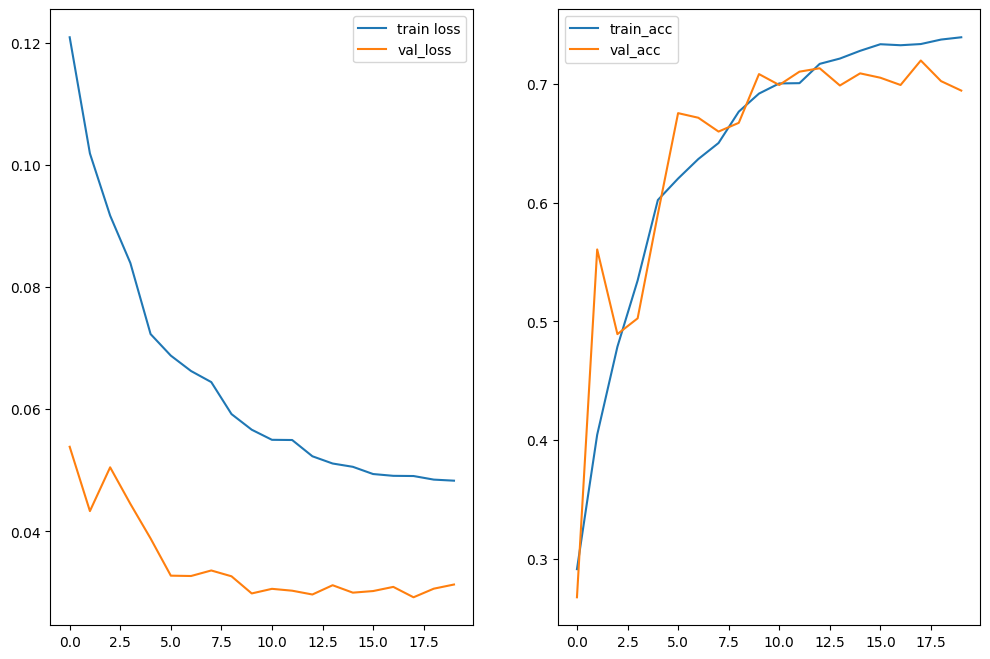

In [49]:
ResNet_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      scheduler=scheduler,
                      epochs=20)

plot_results(ResNet_results)

In [51]:
#save model 
torch.save(model.state_dict(), 'model_weights_aug.pth')

In [52]:
model = resnet34() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights_aug.pth'))
#model.eval()

<All keys matched successfully>

Epoch::   0%|          | 0/8 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

Train iter::   0%|          | 0/901 [00:00<?, ?it/s]

Val iter::   0%|          | 0/164 [00:00<?, ?it/s]

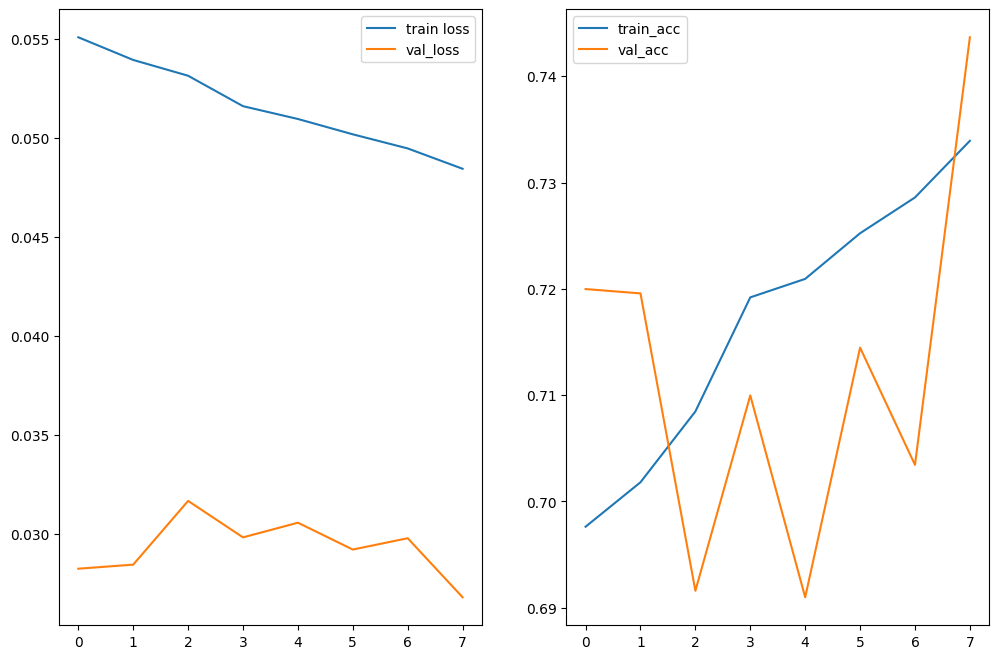

In [105]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
ResNet_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      scheduler=scheduler,
                      epochs=8)

plot_results(ResNet_results)

In [19]:
model = resnet34() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights2.pth'))

<All keys matched successfully>

#### get accuracy for model predictions on different classes of distress

In [20]:
labels_dict = {"crack_alligator_area": 0, "crack_longitudinal": 1, "crack_reflection": 2, 
               "crack_transversal": 3, "patches": 4, "pothole": 5, "raveling": 6}
inv_labels_dict = {v: k for k, v in labels_dict.items()}
classes = labels_dict.keys()
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        labels = labels.type(torch.LongTensor)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[inv_labels_dict[int(label)]] += 1
            total_pred[inv_labels_dict[int(label)]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: crack_alligator_area is 5.0 %
Accuracy for class: crack_longitudinal is 64.3 %
Accuracy for class: crack_reflection is 61.2 %
Accuracy for class: crack_transversal is 67.4 %
Accuracy for class: patches is 40.6 %
Accuracy for class: pothole is 83.0 %
Accuracy for class: raveling is 34.5 %
